# 데이터 불러오기

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: /home/soohyun/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [16]:
import torch
import os

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
train_dir = "./data/chest_xray/train"
val_dir = "./data/chest_xray/test"
test_dir = "./data/chest_xray/val"

In [18]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2

transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


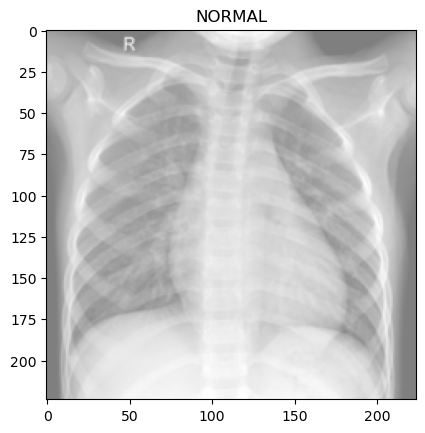

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))


# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

In [20]:
# 데이터 전처리 정의
data_transforms = {
    "train": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.RandomCrop((200, 200)),  # 랜덤 크롭 (200x200)
            v2.RandomRotation(20),  # 랜덤 회전 (-20도 ~ 20도)
            v2.ToTensor(),  # 텐서로 변환
            v2.Normalize([0.5], [0.5]),  # 정규화
        ]
    ),
    "val": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.ToTensor(),  # 텐서로 변환
            v2.Normalize([0.5], [0.5]),  # 정규화
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.ToTensor(),  # 텐서로 변환
            v2.Normalize([0.5], [0.5]),  # 정규화
        ]
    ),
}

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [21]:
from torchvision import datasets
from torch.utils.data import DataLoader

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms["val"])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5216
Number of validation samples: 624
Number of test samples: 16


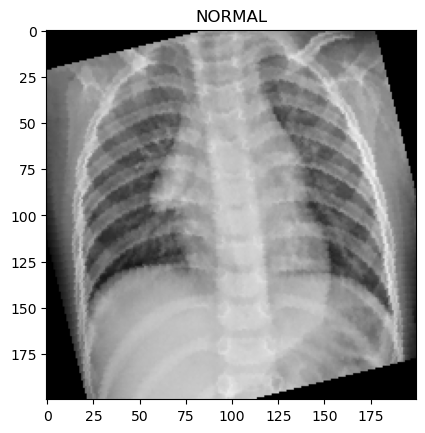

In [22]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))


# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

# Custom CNN 모델 생성

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1
        )  # 입력 채널: 3, 출력 채널: 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv2D
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive Pooling (7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully Connected Layer
        self.fc2 = nn.Linear(128, num_classes)  # Output Layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pooling
        x = self.avgpool(x)  # Adaptive Pooling
        x = torch.flatten(x, 1)  # Flattening
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.fc2(x)  # Output Layer
        return x


# 클래스 수 설정 (NORMAL, PNEUMONIA)
num_classes = len(class_names)

In [24]:
import torch.optim as optim

model = CustomCNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 및 평가

In [25]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    step = 0
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            step += 1

        # 학습 손실 및 정확도 출력
        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # 검증 단계 수행
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [26]:
def evaluate(model, dataloader, loss_fn):
    model.eval()

    losses = []  # 손실값을 저장할 리스트
    correct = 0  # 올바르게 예측한 샘플 수
    total = 0  # 전체 샘플 수

    with torch.no_grad():
        for inputs, labels in dataloader:
            # 데이터를 GPU 또는 CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델의 예측값 계산
            outputs = model(inputs)

            # 손실값 계산
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # 예측값 가져오기
            pred_labels = torch.argmax(outputs, dim=1)  # [배치 크기]
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

    # 평균 손실값과 정확도 계산
    avg_loss = sum(losses) / len(losses)
    accuracy = correct / total

    return avg_loss, accuracy

In [27]:
train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.3451, Train Acc: 0.8497, Val Loss: 0.3698, Val Acc: 0.8285
Epoch 2/10, Train Loss: 0.2111, Train Acc: 0.9135, Val Loss: 0.3283, Val Acc: 0.8638
Epoch 3/10, Train Loss: 0.1859, Train Acc: 0.9277, Val Loss: 0.4867, Val Acc: 0.8494
Epoch 4/10, Train Loss: 0.1654, Train Acc: 0.9371, Val Loss: 0.3541, Val Acc: 0.8654
Epoch 5/10, Train Loss: 0.1531, Train Acc: 0.9429, Val Loss: 0.4665, Val Acc: 0.8494
Epoch 6/10, Train Loss: 0.1405, Train Acc: 0.9475, Val Loss: 0.4716, Val Acc: 0.8526
Epoch 7/10, Train Loss: 0.1380, Train Acc: 0.9475, Val Loss: 0.3975, Val Acc: 0.8766
Epoch 8/10, Train Loss: 0.1290, Train Acc: 0.9546, Val Loss: 0.3180, Val Acc: 0.8814
Epoch 9/10, Train Loss: 0.1197, Train Acc: 0.9578, Val Loss: 0.4019, Val Acc: 0.8670
Epoch 10/10, Train Loss: 0.1179, Train Acc: 0.9559, Val Loss: 0.4134, Val Acc: 0.8798


In [28]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)
test_acc

0.6875

# Transfer Learning

In [29]:
import torchvision.models as models

# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor 동결 (파라미터 업데이트 불가)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Classifier 교체 (기존 Fully Connected Layer를 새로운 Classifier로 교체)
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/soohyun/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 11.5MB/s]


In [30]:
print(pretrained_model.fc.weight.device)

cuda:0


In [31]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 1.1496, Train Acc: 0.2696, Val Loss: 0.7824, Val Acc: 0.4119
Epoch 2/10, Train Loss: 1.1473, Train Acc: 0.2699, Val Loss: 0.7754, Val Acc: 0.4263
Epoch 3/10, Train Loss: 1.1512, Train Acc: 0.2686, Val Loss: 0.7835, Val Acc: 0.4119
Epoch 4/10, Train Loss: 1.1528, Train Acc: 0.2713, Val Loss: 0.7858, Val Acc: 0.4151
Epoch 5/10, Train Loss: 1.1463, Train Acc: 0.2697, Val Loss: 0.7832, Val Acc: 0.4103
Epoch 6/10, Train Loss: 1.1472, Train Acc: 0.2676, Val Loss: 0.7866, Val Acc: 0.4038
Epoch 7/10, Train Loss: 1.1385, Train Acc: 0.2736, Val Loss: 0.7926, Val Acc: 0.4022
Epoch 8/10, Train Loss: 1.1426, Train Acc: 0.2732, Val Loss: 0.7801, Val Acc: 0.4327
Epoch 9/10, Train Loss: 1.1492, Train Acc: 0.2678, Val Loss: 0.7833, Val Acc: 0.4135
Epoch 10/10, Train Loss: 1.1504, Train Acc: 0.2661, Val Loss: 0.7751, Val Acc: 0.4311


(0.7811039090156555, 0.3125)

# Transfer Learning (Partial Fine-Tuning)

In [32]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor의 초기 층 동결
for name, param in pretrained_model.named_parameters():
    if (
        "layer4" in name or "fc" in name
    ):  # ResNet의 마지막 블록(layer4)와 Fully Connected Layer만 학습 가능
        param.requires_grad = True
    else:
        param.requires_grad = False

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성

print("Trainable parameters:")
for name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        print(name)

pretrained_model = pretrained_model.to(device)

Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [33]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.6513, Train Acc: 0.7149, Val Loss: 0.7895, Val Acc: 0.6170
Epoch 2/10, Train Loss: 0.6462, Train Acc: 0.7111, Val Loss: 0.7890, Val Acc: 0.6138
Epoch 3/10, Train Loss: 0.6512, Train Acc: 0.7132, Val Loss: 0.7831, Val Acc: 0.6106
Epoch 4/10, Train Loss: 0.6499, Train Acc: 0.7157, Val Loss: 0.7858, Val Acc: 0.6154
Epoch 5/10, Train Loss: 0.6506, Train Acc: 0.7111, Val Loss: 0.7809, Val Acc: 0.6106
Epoch 6/10, Train Loss: 0.6524, Train Acc: 0.7134, Val Loss: 0.7881, Val Acc: 0.6170
Epoch 7/10, Train Loss: 0.6522, Train Acc: 0.7103, Val Loss: 0.7899, Val Acc: 0.6122
Epoch 8/10, Train Loss: 0.6485, Train Acc: 0.7141, Val Loss: 0.7871, Val Acc: 0.6106
Epoch 9/10, Train Loss: 0.6480, Train Acc: 0.7134, Val Loss: 0.7906, Val Acc: 0.6154
Epoch 10/10, Train Loss: 0.6506, Train Acc: 0.7143, Val Loss: 0.7853, Val Acc: 0.6122


(0.9021009802818298, 0.5)

# Transfer Learning (Full Fine-Tuning)

In [34]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

In [35]:
# 손실 함수와 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    pretrained_model.parameters(), lr=0.00001
)  # Full Fine-Tuning에서는 더 낮은 학습률

In [36]:
# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.4174, Train Acc: 0.7885, Val Loss: 0.3863, Val Acc: 0.8317
Epoch 2/10, Train Loss: 0.1359, Train Acc: 0.9576, Val Loss: 0.3272, Val Acc: 0.8718
Epoch 3/10, Train Loss: 0.0998, Train Acc: 0.9661, Val Loss: 0.3327, Val Acc: 0.8798
Epoch 4/10, Train Loss: 0.0812, Train Acc: 0.9718, Val Loss: 0.4495, Val Acc: 0.8590
Epoch 5/10, Train Loss: 0.0734, Train Acc: 0.9778, Val Loss: 0.4147, Val Acc: 0.8574
Epoch 6/10, Train Loss: 0.0712, Train Acc: 0.9753, Val Loss: 0.4505, Val Acc: 0.8542
Epoch 7/10, Train Loss: 0.0596, Train Acc: 0.9791, Val Loss: 0.4256, Val Acc: 0.8606
Epoch 8/10, Train Loss: 0.0608, Train Acc: 0.9808, Val Loss: 0.3695, Val Acc: 0.8910
Epoch 9/10, Train Loss: 0.0597, Train Acc: 0.9793, Val Loss: 0.4619, Val Acc: 0.8686
Epoch 10/10, Train Loss: 0.0454, Train Acc: 0.9852, Val Loss: 0.4482, Val Acc: 0.8782


(0.36116841435432434, 0.75)